# METABOLOMIC ANALYSIS 

## Import Processed Cardinal Spectral Data

In [1]:
library(Seurat)
library(Cardinal)
library(ggplot2)
library(rhdf5)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: ProtGenerics


Attaching package: ‘ProtGenerics’


The following object is masked from ‘package:stats’:

    smooth


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.

In [2]:
all_data_binned <- readRDS("/QRISdata/Q1851/Andrew_C/Metabolomics/Analysis/All_Samples/Refined/All_Samples_Binned_Data.RDS")
all_data_ssc <- readRDS("/QRISdata/Q1851/Andrew_C/Metabolomics/Analysis/All_Samples/All_Samples_ssc.RDS")

## Add Segmentation Annotations

In [3]:
add_tumour_annotation <- function(data_binned, data_ssc, cancer_class){
  
  data_bin <- data_binned
  classes <- resultData(data_ssc)[[6]][[1]]
  pixel_data <- pixelData(data_bin)
  
  
  cancer_class_column <- c()
  for (row in classes){
    cancer <- FALSE
    if (row == cancer_class){
         cancer <- TRUE
    }
    cancer_class_column <- c(cancer_class_column,cancer)
  }
      
  pixel_data[["cancer_class"]] <- cancer_class_column
  
  treatment_list <- c()
  
  for (run in pixel_data@run){
    
    treated <- "Control"
    if (run == "VLP94C/vlp94c_dhb"|| run == "VLP94D/vlp94d_dhb"){
      treated <- "Treated"
    }
    treatment_list <- c(treatment_list, treated)
    
  }
  
  pixel_data[["treatment_class"]] <- treatment_list
  
  pixel_data[["region"]] <- classes
  
  pixelData(data_bin) <- pixel_data
  return(data_bin)

}


In [4]:
all_data <- add_tumour_annotation(all_data_binned, all_data_ssc, "3")

### Pull Coordinates for Mapping

In [5]:
get_old_coords <- function(all_data, run_name, out_dir){
    subset <- subsetPixels(all_data, run(all_data) == run_name)
    x <- pixelData(subset)[[1,]]
    y <- pixelData(subset)[[2,]]
    coords <- data.frame(x = x, y= y)
    write.csv(coords, file = paste0(out_dir, strsplit(run_name,"/")[[1]][1],".csv"))
}

In [ ]:
#Run1
out_dir <- "/QRISdata/Q1851/Andrew_C/Metabolomics/Xiao_coords/"
get_old_coords(all_data,"VLP94A/vlp94a_dhb", out_dir)
get_old_coords(all_data,"VLP94C/vlp94c_dhb", out_dir)
#Run2
get_old_coords(all_data,"VLP94B/vlp94b_dhb", out_dir)
get_old_coords(all_data,"VLP94D/vlp94d_dhb", out_dir)


## Create Seurat Objects

In [7]:
## Import Coordinate File
mapped_A <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/Xiao_coords/mapped_a_v1.csv")
mapped_B <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/Xiao_coords//mapped_b_v1.csv")
mapped_C <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/Xiao_coords//mapped_c_v1.csv")
mapped_D <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/Xiao_coords/mapped_d_v1.csv")


mapped_A <- mapped_A[c("X_new","Y_new")]
mapped_B <- mapped_B[c("X_new","Y_new")]
mapped_C <- mapped_C[c("X_new","Y_new")]
mapped_D <- mapped_D[c("X_new","Y_new")]


head(mapped_C)

,X_new,Y_new
,<dbl>,<dbl>
1,919.0569,1535.939
2,970.9020,1524.045
3,957.9407,1524.045
4,944.9794,1524.045
5,932.0182,1524.045
6,919.0569,1524.045


In [8]:
cardinal_to_seurat <- function(data,run_name, seurat.coord = NULL, export.counts.path = NULL){
  
  run_data <- subsetPixels(data, run(data) == paste0(run_name))
  sparse_matrix <- as.sparse(spectra(run_data))
  
  if (!(is.null(seurat.coord))){
    pixel_data <- pixelData(run_data)
    pixel_data[[1,]] <- seurat.coord$X_new # changes coordinates to matched Visium Object
    pixel_data[[2,]] <- seurat.coord$Y_new
    pixelData(run_data) <- pixel_data 
  }
  
  spot_name <- c()
  
  for(idx in seq(1,length(pixelData(run_data)[[1]]))){
    x_coord <- pixelData(run_data)[[1,]][idx]
    y_coord <- pixelData(run_data)[[2,]][idx]
    name <- paste0(x_coord,"_",y_coord)
    spot_name <- c(spot_name, name)
  }

  colnames(sparse_matrix)<- spot_name
  rownames(sparse_matrix)<- paste("mz-", featureData(run_data)@mz, sep = "") 

  if (!(is.null(export.counts.path))){
    write.csv(t(sparse_matrix), file = export.counts.path) 
  }
  
  seuratobj <- CreateSeuratObject(sparse_matrix, assay = "Spatial")
  seuratobj <- AddMetaData(seuratobj,col.name = "cancer_class", metadata = pixelData(run_data)[[4,]])
  seuratobj <- AddMetaData(seuratobj,col.name = "treatment_class", metadata = pixelData(run_data)[[5,]])
  seuratobj <- AddMetaData(seuratobj,col.name = "ssc_region", metadata = pixelData(run_data)[[6,]])
  
  
  ## Add spatial data
  cents <- CreateCentroids(data.frame(x = c(pixelData(run_data)[[1,]]), y = c(pixelData(run_data)[[2,]]), cell = c(spot_name)))


  segmentations.data <- list(
    "centroids" = cents,
    "segmentation" = NULL
  )

  coords <- CreateFOV(
    coords = segmentations.data,
    type = c("segmentation", "centroids"),
    molecules = NULL,
    assay = "Spatial"
  )

  seuratobj[["fov"]] <- coords
  
  return(seuratobj)
}


In [10]:
#Run1
#seurat_A <- cardinal_to_seurat(all_data,"VLP94A/vlp94a_dhb", seurat.coord = mapped_A, export.counts.path ="/QRISdata/Q1851/Andrew_C/Metabolomics/mapped_sparse_A.csv")
#seurat_C <- cardinal_to_seurat(all_data,"VLP94C/vlp94c_dhb", seurat.coord = mapped_C, export.counts.path ="/QRISdata/Q1851/Andrew_C/Metabolomics/mapped_sparse_C.csv")
#Run2
seurat_B <- cardinal_to_seurat(all_data,"VLP94B/vlp94b_dhb", seurat.coord = mapped_B, export.counts.path ="/QRISdata/Q1851/Andrew_C/Metabolomics/mapped_sparse_B.csv")
seurat_D <- cardinal_to_seurat(all_data,"VLP94D/vlp94d_dhb", seurat.coord = mapped_D, export.counts.path ="/QRISdata/Q1851/Andrew_C/Metabolomics/mapped_sparse_D.csv")


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 7.4 GiB”


## Find-Nearest m/z value

In [79]:
find_nearest <- function(data, target_mz){
  
  numbers <- as.numeric(gsub("mz-", "", Features(data)))
  closest_number <- numbers[which.min(abs(numbers - target_mz))]
  return(paste0("mz-",closest_number))
}

### CURRENTLY BLEND FUNCTIONALITY IN IMAGEFEATUREPLOT IS BROKEN WAITING FOR SOLVE
plusminus <- function(data, target_mz, plus_minus){
    feature_list <- c()
    center <- find_nearest(data, target_mz)
    
    center_value <- as.numeric(gsub("mz-", "", center))
    up_value <- center_value + plus_minus 
    low_value <- center_value - plus_minus

    upper <- find_nearest(data, up_value)
    lower <- find_nearest(data, low_value)

    feature_list <- c(feature_list, center)
    if (!(upper %in% feature_list)){
        feature_list <- c(feature_list, upper)
    }
    if (!(lower %in% feature_list)){
        feature_list <- c(feature_list, lower)
    }

    if (length(feature_list) == 1){
        print("No other m/z peaks in plusminus range -> increase to include more peaks")
    }
    return(feature_list)
}

## Test Seruat Object

Warning message:
“No layers found matching search pattern provided”
Warning message in FetchData.Assay5(object = object[[DefaultAssay(object = object)]], :
“data layer is not found and counts layer is used”


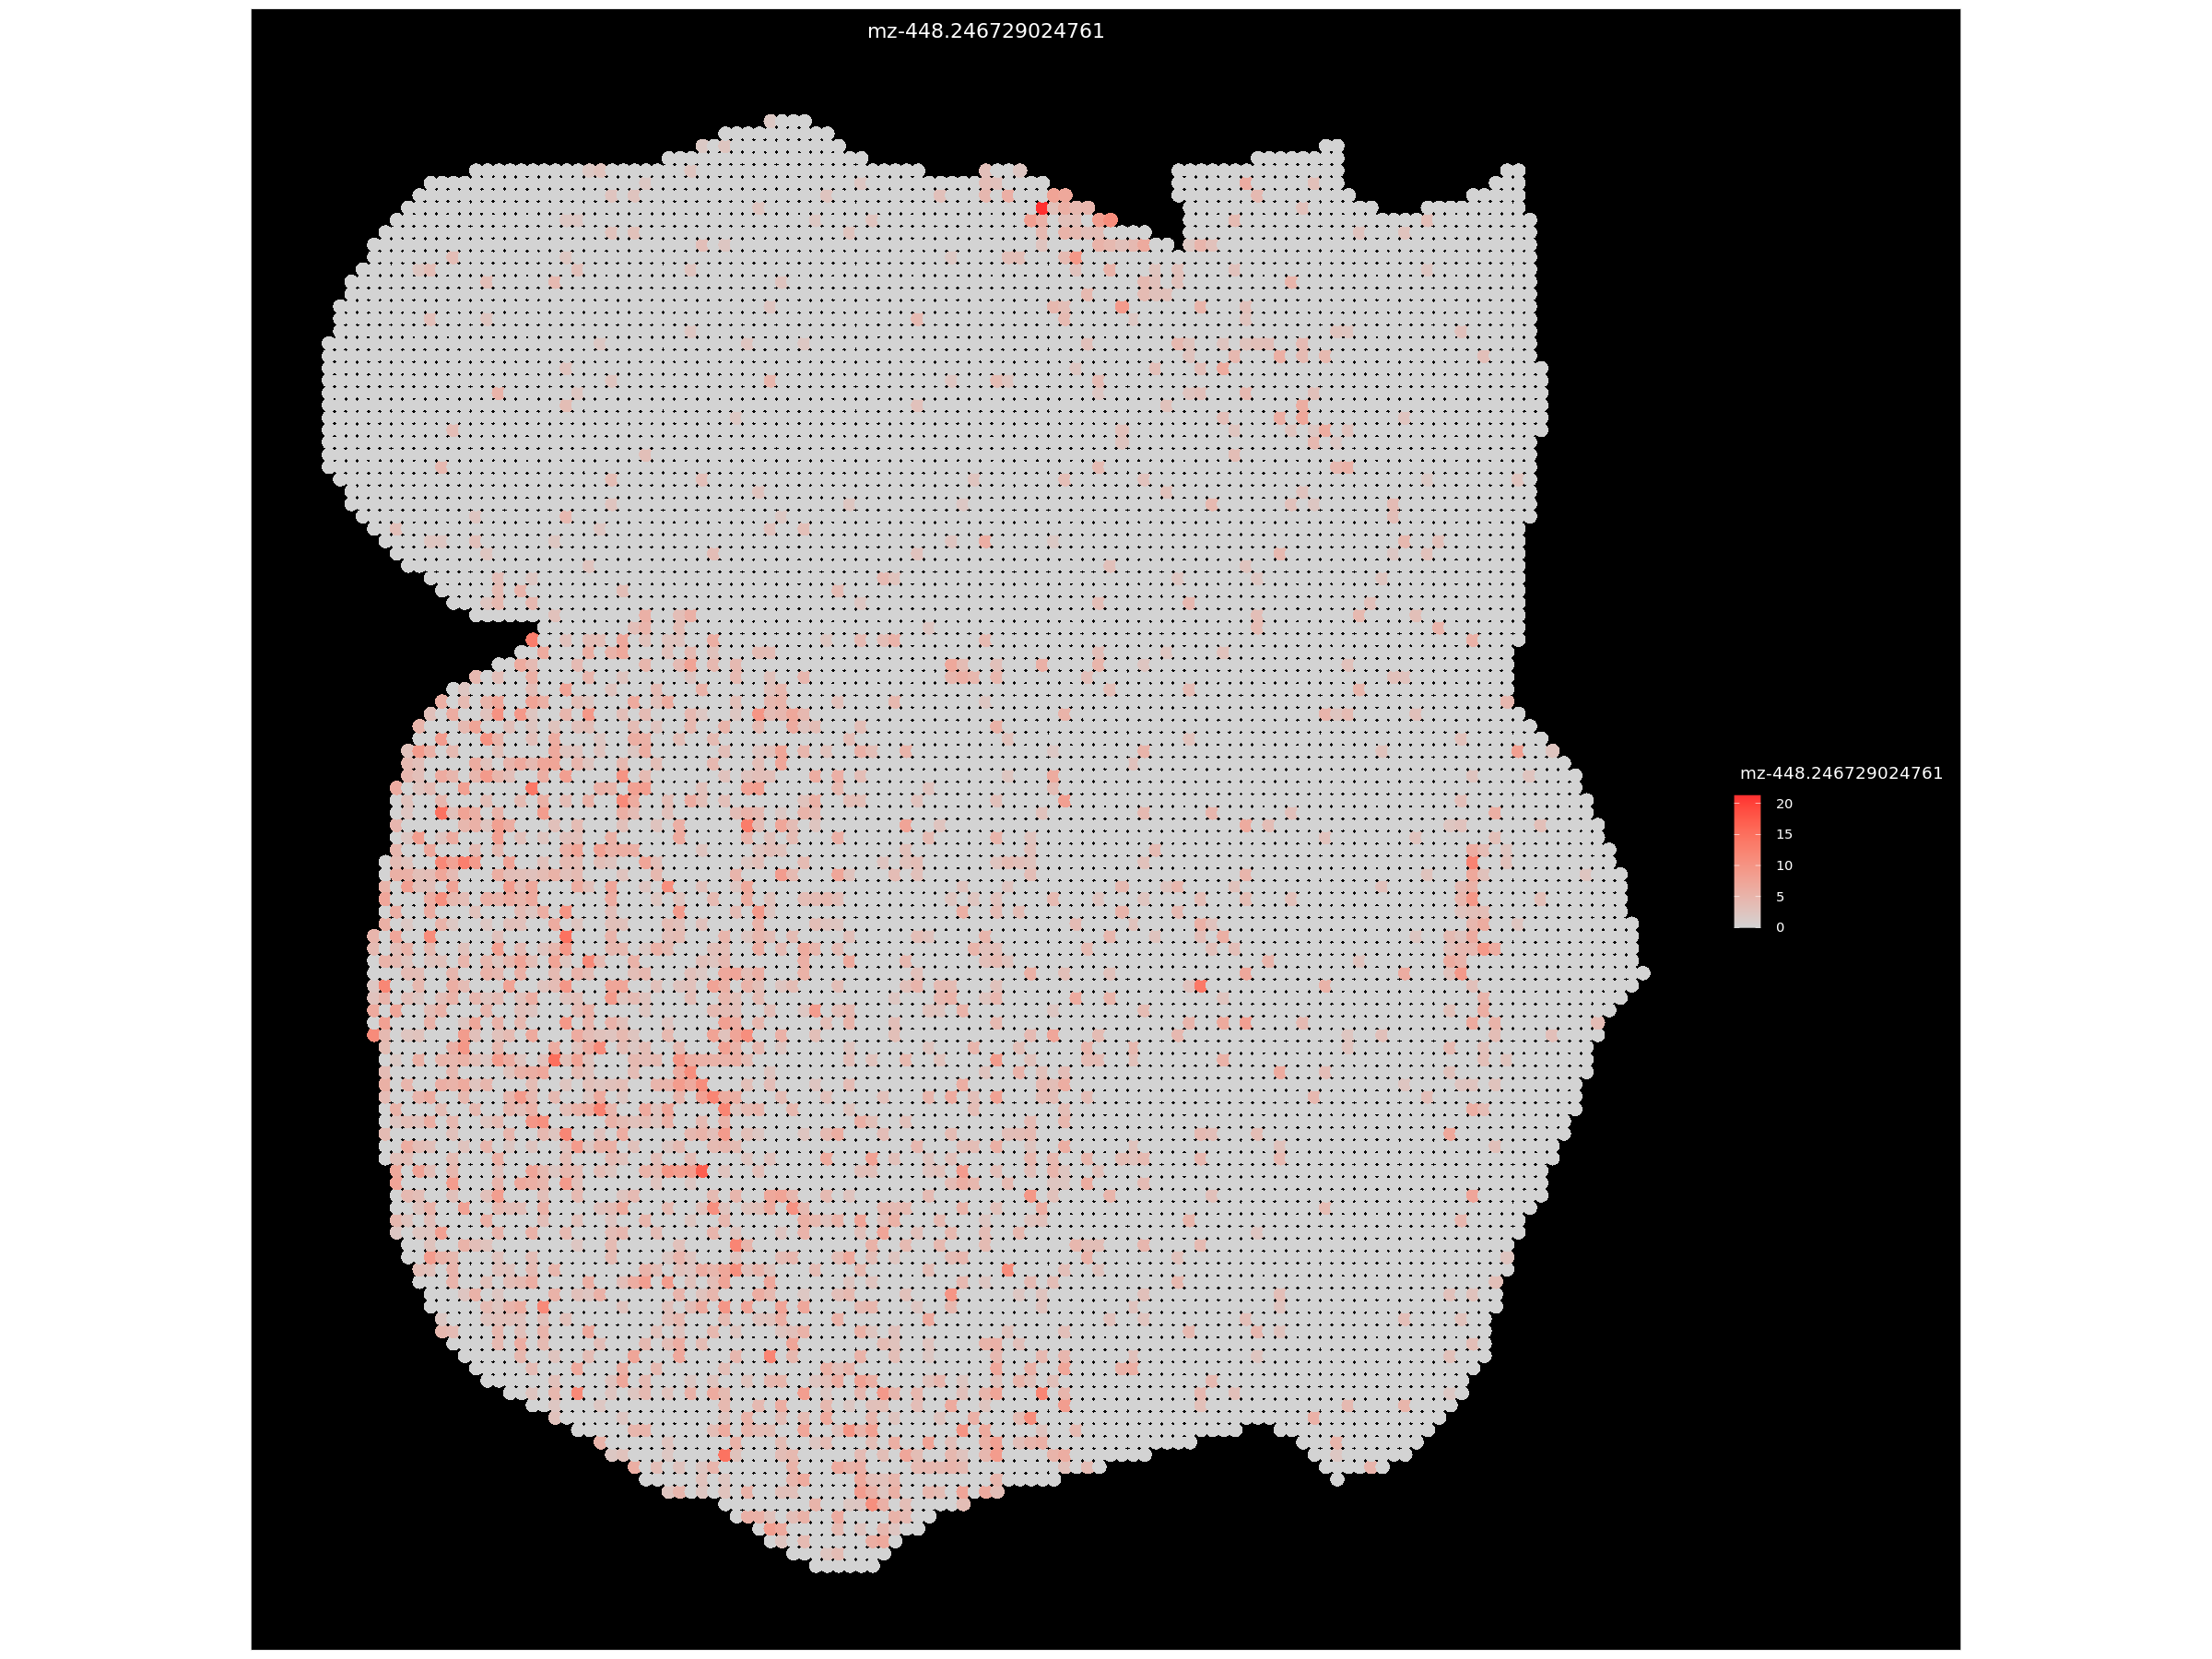

In [80]:
options(repr.plot.width = 20, repr.plot.height = 15) # Changes Image View Size
ImageFeaturePlot(seurat_C, fov = "fov", features = c(find_nearest(seurat_A,448.245)), size = 4.4, axes = FALSE, border.color = "grey", dark.background = TRUE)

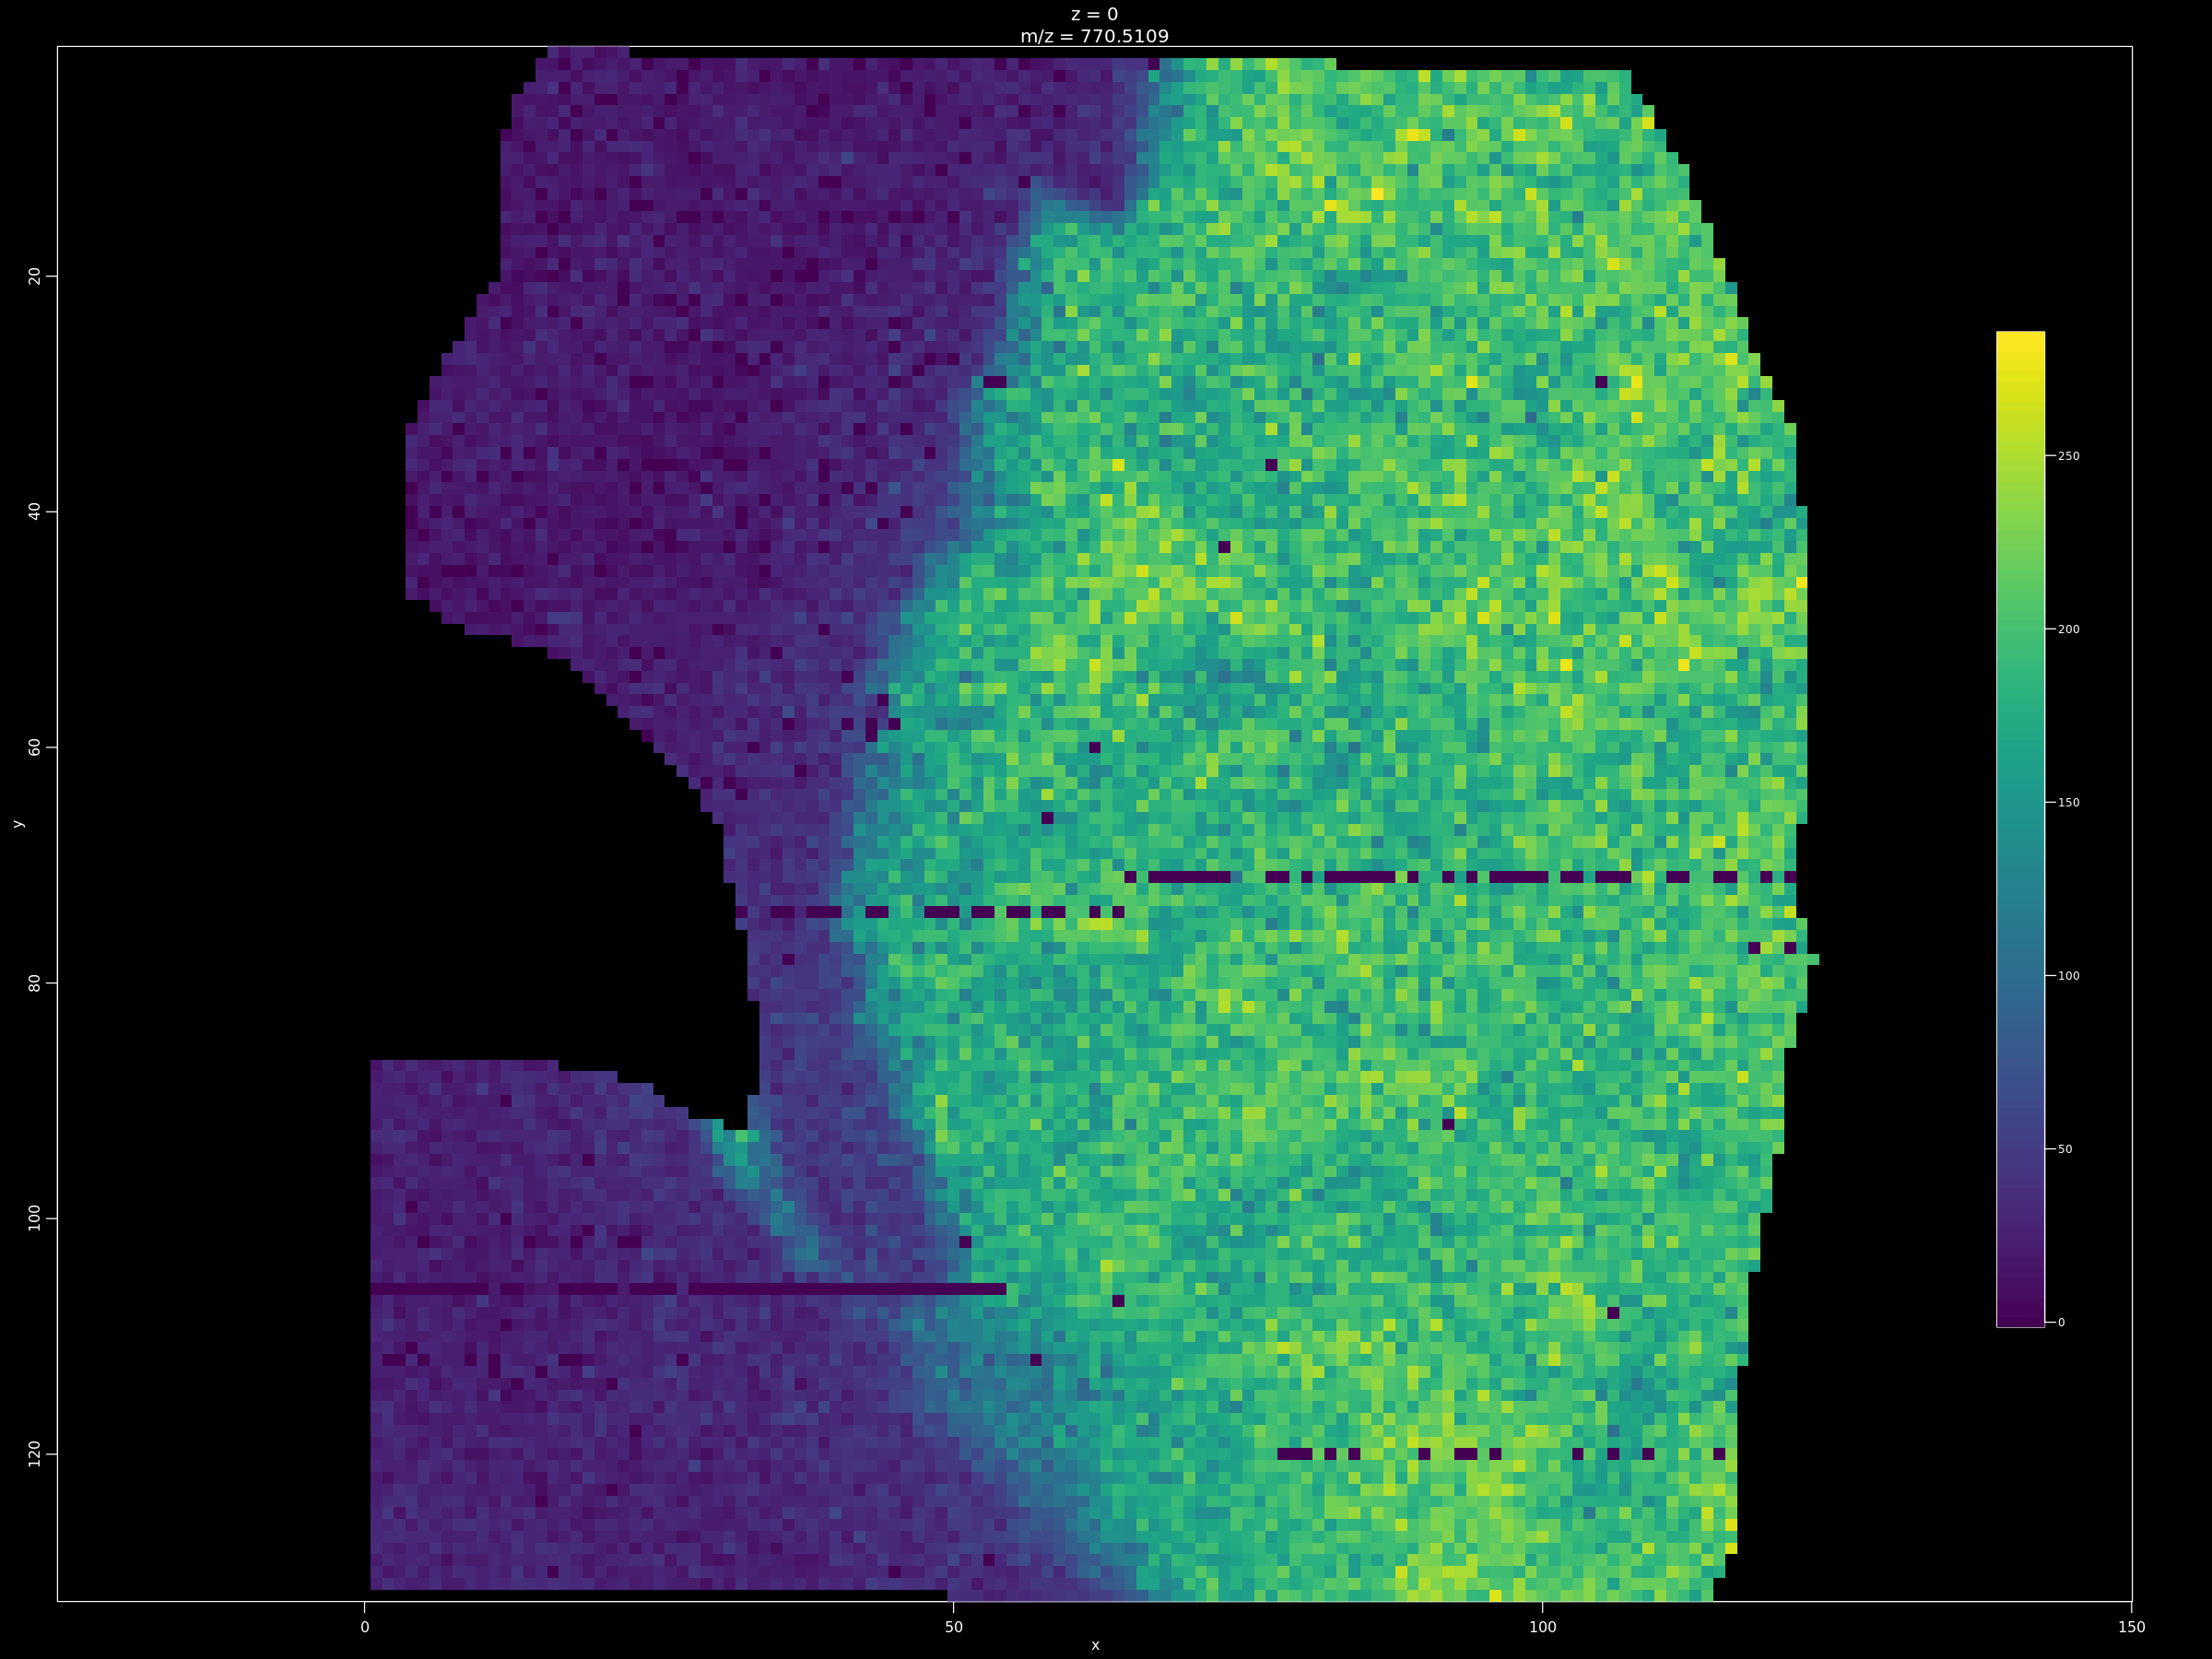

In [11]:
A <- subsetPixels(all_data, run(all_data) == "VLP94A/vlp94a_dhb")

darkmode()
image(A, mz = 770.5109)

## Compare with Visium

In [43]:
read_10Xvisium <- function(input_dir){
    
    ### Set up data Directory
    print("Import - Importing data...")
    ###Load Visium data
    image_data <- Read10X_Image(paste0(input_dir,"/spatial/"))
    image_data@assay <- "Spatial"
    image_data@key <- "slice1_"
  
    mtx_data <- Read10X(input_dir)
  
    data <- CreateSeuratObject(counts = mtx_data, assay = "Spatial")
    data@images <- list("slice1" = image_data)
    return(data)
}   

In [44]:
visium_a <- read_10Xvisium("/QRISdata/Q1851/Xiao/Working_project/Tuan_project/VLP94_A/")

In [45]:
test <- Load10X_Spatial("/QRISdata/Q1851/Xiao/Working_project/Tuan_project/VLP94_A/")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [48]:
test@assays$Spatial$counts

  [[ suppressing 32 column names ‘AAACAAGTATCTCCCA-1’, ‘AAACACCAATAACTGC-1’, ‘AAACAGAGCGACTCCT-1’ ... ]]

  [[ suppressing 32 column names ‘AAACAAGTATCTCCCA-1’, ‘AAACACCAATAACTGC-1’, ‘AAACAGAGCGACTCCT-1’ ... ]]

  [[ suppressing 32 column names ‘AAACAAGTATCTCCCA-1’, ‘AAACACCAATAACTGC-1’, ‘AAACAGAGCGACTCCT-1’ ... ]]



68886 x 4134 sparse Matrix of class "dgCMatrix"
                                                                                              
hg38-MIR1302-2HG  . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-FAM138A      . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-OR4F5        . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.1   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.3   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.2   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.5   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.4   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AP006222.2   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg

In [63]:
visium_a[["Spatial"]]$data <- as.numeric(visium_a[["Spatial"]]$counts)

Warning message in .M2v(x):
“sparse->dense coercion: allocating vector of size 2.1 GiB”
Warning message in seq_len(length.out = dim(x = value)[fdim]):
“first element used of 'length.out' argument”


In [62]:
test@assays$Spatial$counts

  [[ suppressing 32 column names ‘AAACAAGTATCTCCCA-1’, ‘AAACACCAATAACTGC-1’, ‘AAACAGAGCGACTCCT-1’ ... ]]

  [[ suppressing 32 column names ‘AAACAAGTATCTCCCA-1’, ‘AAACACCAATAACTGC-1’, ‘AAACAGAGCGACTCCT-1’ ... ]]

  [[ suppressing 32 column names ‘AAACAAGTATCTCCCA-1’, ‘AAACACCAATAACTGC-1’, ‘AAACAGAGCGACTCCT-1’ ... ]]



68886 x 4134 sparse Matrix of class "dgCMatrix"
                                                                                              
hg38-MIR1302-2HG  . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-FAM138A      . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-OR4F5        . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.1   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.3   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.2   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.5   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AL627309.4   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg38-AP006222.2   . .  . . . . . . . .  . .  . .  . . .  .  .  . .  . . .  .  .  . . . .  .  .
hg

In [57]:
test@images$slice1@coordinates

,tissue,row,col,imagerow,imagecol
,<chr>,<chr>,<chr>,<chr>,<chr>
AAACAAGTATCTCCCA-1,1,50,102,3191,5401
AAACACCAATAACTGC-1,1,59,19,7381,6218
AAACAGAGCGACTCCT-1,1,14,94,3615,2238
AAACAGCTTTCAGAAG-1,1,43,9,7895,4814
AAACAGGGTCTATATT-1,1,47,13,7691,5164
AAACAGTGTTCCTGGG-1,1,73,43,6161,7442
AAACATGGTGAGAGGA-1,1,62,0,8340,6487
AAACATTTCCCGGATT-1,1,61,97,3438,6370
AAACCCGAACGAAATC-1,1,45,115,2537,4958


In [59]:
SpatialFeaturePlot(test, feature = c("nCount_Spatial"), images = "slice1")

ERROR: Error in FUN(left, right): non-numeric argument to binary operator


In [15]:
library(ggplot2)

M_V_plot <- function(adata, df_maldi, library_id = NULL, name = NULL, data_alpha = 0.8, tissue_alpha = 1.0, cmap = "Spectral", spot_size = c(5, 40), show_color_bar = TRUE, show_size_legend = TRUE, show_axis = FALSE, cropped = TRUE, margin = 100, dpi = 150, output = NULL) {
  # Extract imagecol and imagerow from AnnData
  imagecol <- adata$obs$imagecol
  imagerow <- adata$obs$imagerow

  # Normalize data
  reads_per_spot <- rowSums(adata$X)
  scaler <- scales::rescale(spot_size, to = range(reads_per_spot))
  reads_per_spot_size <- scaler[findInterval(reads_per_spot, seq(spot_size[1], spot_size[2], length.out = length(scaler)))]

  genes_per_spot <- rowSums(adata$X > 0)

  # Initialize a ggplot object
  p <- ggplot() +
    geom_point(data = data.frame(imagecol, imagerow, genes_per_spot, reads_per_spot_size), aes(x = imagecol, y = imagerow, size = reads_per_spot_size, color = genes_per_spot), shape = 1, alpha = data_alpha) +
    scale_size_continuous(range = spot_size, guide = FALSE) +
    scale_color_viridis(trans = "log", name = "Number of Genes") +
    geom_point(data = df_maldi, aes(x = X_new, y = Y_new, size = values), shape = 4, alpha = 0.5, color = "darkred") +
    scale_size_continuous(range = c(5, 40), guide = FALSE) +
    theme_minimal()

  if (show_color_bar) {
    p <- p + scale_color_viridis(trans = "log", name = "Number of Genes") +
      theme(legend.position = c(0.2, 0.73)) +
      guides(size = guide_legend(title = "Number of Reads"))
  }

  if (show_size_legend) {
    p <- p + scale_size(range = c(5, 40), guide = FALSE) +
      theme(legend.position = c(0.2, 0.23)) +
      guides(size = guide_legend(title = "Mapped Maldi"))
  }

  if (!show_axis) {
    p <- p + theme_void()
  }

  if (is.null(library_id)) {
    library_id <- names(adata$uns$spatial)[1]
  }

  image <- adata$uns$spatial[[library_id]]$images[adata$uns$spatial[[library_id]]$use_quality]
  p <- p + annotation_raster(image, -Inf, Inf, -Inf, Inf, interpolate = TRUE, alpha = tissue_alpha)

  if (cropped) {
    p <- p + coord_cartesian(xlim = c(min(imagecol) - margin, max(imagecol) + margin), ylim = c(min(imagerow) - margin, max(imagerow) + margin))
  }

  if (!is.null(output)) {
    ggsave(file = paste0(output, "/", name), plot = p, width = 10, height = 8, dpi = dpi)
  }

  return(p)
}

# Example usage:
# M_V_plot(adata, df_maldi, name = "output_plot.png")


In [ ]:
M_V_plot(

In [19]:
seurat_A@assays$Spatial$counts[1:5,1:2]

5 x 2 sparse Matrix of class "dgCMatrix"
                    27483.480469_9402.649414 27533.480469_9402.649414
mz-160.129652502176                        .                        .
mz-160.131253806708                        .                        .
mz-160.132855127252                        .                        .
mz-160.13445646381                         .                        .
mz-161.127151673518                        .                        .

## Generate Custom Colour Map 

In [ ]:
library(Seurat)
library(ggplot2)
library(scales)

In [ ]:
get.custom.jet <- function(n = 35, alpha = 1 ) { ####FUNCTION FROM CARDINAL)
	col2 <- rainbow(9*n, alpha=alpha)[1:(6*n)]
	f <- colorRamp(c("darkred", rainbow(n)[1]))
	g <- colorRamp(c(col2[length(col2)], "darkblue"))
	alpha <- col2rgb(col2, alpha=TRUE)[[4]]
	col1 <- sapply(seq(from=0, to=1, length.out=n), function(i) do.call("rgb",
		c(as.list(f(i)), maxColorValue=255, alpha=alpha)))
	col3 <- sapply(seq(from=0, to=1, length.out=n), function(i) do.call("rgb",
		c(as.list(g(i)), maxColorValue=255, alpha=alpha)))
	cols <- rev(c(col1, col2, col3))
	jet <- cols[seq(from=1, to=8*n, by=8)]


    ### Adds Black for low values, and lowers blue scale
    custom_palette <- c(colorRampPalette(c("#00008BFF", "#00F0FFFF"))(10),jet[15:35])
    new_jet <- c(rep("#161616",2),custom_palette[3:32])
    return(new_jet)                    
}
new_pal <- get.custom.jet()
show_col(new_pal)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 15) # Changes Image View Size

(ImageFeaturePlot(data, fov = "fov", features = c(find_nearest(data,448.245)), size = 2, axes = FALSE, border.color = "black", dark.background = TRUE)+ scale_fill_gradientn(limits= c(0,35),colours = new_pal,na.value = "black"))+
(ImageFeaturePlot(data, fov = "fov.2", features = c(find_nearest(data,448.245)), size = 2, axes = FALSE, border.color = "black", dark.background = TRUE)+ scale_fill_gradientn(limits= c(0,35),colours = new_pal,na.value = "black"))+
(ImageFeaturePlot(data, fov = "fov.3", features = c(find_nearest(data,448.245)), size = 2, axes = FALSE, border.color = "black", dark.background = TRUE)+ scale_fill_gradientn(limits= c(0,35),colours = new_pal,na.value = "black"))+
(ImageFeaturePlot(data, fov = "fov.4", features = c(find_nearest(data,448.245)), size = 2, axes = FALSE, border.color = "black", dark.background = TRUE)+ scale_fill_gradientn(limits= c(0,35),colours = new_pal,na.value = "black"))



In [ ]:
library(ggplot2)

M_V_plot <- function(adata, df_maldi, library_id = NULL, name = NULL, data_alpha = 0.8, tissue_alpha = 1.0, cmap = "Spectral", spot_size = c(5, 40), show_color_bar = TRUE, show_size_legend = TRUE, show_axis = FALSE, cropped = TRUE, margin = 100, dpi = 150, output = NULL) {
  # Extract imagecol and imagerow from AnnData
  imagecol <- adata$obs$imagecol
  imagerow <- adata$obs$imagerow

  # Normalize data
  reads_per_spot <- rowSums(adata$X)
  scaler <- scales::rescale(spot_size, to = range(reads_per_spot))
  reads_per_spot_size <- scaler[findInterval(reads_per_spot, seq(spot_size[1], spot_size[2], length.out = length(scaler)))]

  genes_per_spot <- rowSums(adata$X > 0)

  # Initialize a ggplot object
  p <- ggplot() +
    geom_point(data = data.frame(imagecol, imagerow, genes_per_spot, reads_per_spot_size), aes(x = imagecol, y = imagerow, size = reads_per_spot_size, color = genes_per_spot), shape = 1, alpha = data_alpha) +
    scale_size_continuous(range = spot_size, guide = FALSE) +
    scale_color_viridis(trans = "log", name = "Number of Genes") +
    geom_point(data = df_maldi, aes(x = X_new, y = Y_new, size = values), shape = 4, alpha = 0.5, color = "darkred") +
    scale_size_continuous(range = c(5, 40), guide = FALSE) +
    theme_minimal()

  if (show_color_bar) {
    p <- p + scale_color_viridis(trans = "log", name = "Number of Genes") +
      theme(legend.position = c(0.2, 0.73)) +
      guides(size = guide_legend(title = "Number of Reads"))
  }

  if (show_size_legend) {
    p <- p + scale_size(range = c(5, 40), guide = FALSE) +
      theme(legend.position = c(0.2, 0.23)) +
      guides(size = guide_legend(title = "Mapped Maldi"))
  }

  if (!show_axis) {
    p <- p + theme_void()
  }

  if (is.null(library_id)) {
    library_id <- names(adata$uns$spatial)[1]
  }

  image <- adata$uns$spatial[[library_id]]$images[adata$uns$spatial[[library_id]]$use_quality]
  p <- p + annotation_raster(image, -Inf, Inf, -Inf, Inf, interpolate = TRUE, alpha = tissue_alpha)

  if (cropped) {
    p <- p + coord_cartesian(xlim = c(min(imagecol) - margin, max(imagecol) + margin), ylim = c(min(imagerow) - margin, max(imagerow) + margin)
  }

  if (!is.null(output)) {
    ggsave(file = paste0(output, "/", name), plot = p, width = 10, height = 8, dpi = dpi)
  }

  return(p)
}

# Example usage:
# M_V_plot(adata, df_maldi, name = "output_plot.png")


## HMDB Parser for R

In [ ]:
library(XML)
library(data.table)
library(foreach)
library(doParallel)

hmdbextract <- function(name, file, num_cores = 2) {
  ns <- c(hmdb = "http://www.hmdb.ca")
  doc <- xmlParse(name)
  metabolites <- getNodeSet(doc, "//hmdb:metabolite", namespaces = ns)
  
  registerDoParallel(cores = num_cores)  # Set the number of CPU cores
  
  result <- foreach(elem = metabolites, .packages = c("XML", "data.table")) %dopar% {
    accession <- xmlValue(elem[["accession"]])
    monisotopic_molecular_weight <- as.numeric(xmlValue(elem[["monisotopic_molecular_weight"]]))
    iupac_name <- xmlValue(elem[["iupac_name"]])
    name <- xmlValue(elem[["name"]])
    chemical_formula <- xmlValue(elem[["chemical_formula"]])
    InChIKey <- xmlValue(elem[["inchikey"]])
    cas_registry_number <- xmlValue(elem[["cas_registry_number"]])
    smiles <- xmlValue(elem[["smiles"]])
    drugbank <- xmlValue(elem[["drugbank_id"]])
    chebi_id <- xmlValue(elem[["chebi_id"]])
    pubchem <- xmlValue(elem[["pubchem_compound_id"]])
    phenol_explorer_compound_id <- xmlValue(elem[["phenol_explorer_compound_id"]])
    food <- xmlValue(elem[["foodb_id"]])
    knapsack <- xmlValue(elem[["knapsack_id"]])
    chemspider <- xmlValue(elem[["chemspider_id"]])
    kegg <- xmlValue(elem[["kegg_id"]])
    meta_cyc <- xmlValue(elem[["meta_cyc_id"]])
    bigg <- xmlValue(elem[["bigg_id"]])
    metlin_id <- xmlValue(elem[["metlin_id"]])
    pdb_id <- xmlValue(elem[["pdb_id"]])
    logpexp <- xmlValue(elem[["experimental_properties"]][[1]][["value"]])
    kingdom <- xmlValue(elem[["taxonomy"]][[1]][["kingdom"]])
    direct_parent <- xmlValue(elem[["taxonomy"]][[1]][["direct_parent"]])
    super_class <- xmlValue(elem[["taxonomy"]][[1]][["super_class"]])
    classorg <- xmlValue(elem[["taxonomy"]][[1]][["class"]])
    sub_class <- xmlValue(elem[["taxonomy"]][[1]][["sub_class"]])
    molecular_framework <- xmlValue(elem[["taxonomy"]][[1]][["molecular_framework"]])
    
    data.table(accession, monisotopic_molecular_weight, iupac_name, name, chemical_formula,
               InChIKey, cas_registry_number, smiles, drugbank, chebi_id, pubchem,
               phenol_explorer_compound_id, food, knapsack, chemspider, kegg, meta_cyc,
               bigg, metlin_id, pdb_id, logpexp, kingdom, direct_parent, super_class,
               classorg, sub_class, molecular_framework)
  }
  
  stopImplicitCluster()  # Clean up parallel processing
  
  result <- rbindlist(result, fill = TRUE)
  fwrite(result, file)
}

# Usage:
# hmdbextract("your_hmdb_file.xml", "output.csv", num_cores = 4)  # Adjust num_cores as needed


In [ ]:
hmdbextract('/QRISdata/Q1851/Andrew_C/Metabolomics/hmdb_metabolites.xml','/QRISdata/Q1851/Andrew_C/Metabolomics/hmdb_test.csv')

In [ ]:
df <- read.csv('/QRISdata/Q1851/Andrew_C/Metabolomics/hmdb_test.csv')
head(df)

## Annotate Peaks from HMDB 

In [ ]:
all_mz <- read.csv('/QRISdata/Q1851/Andrew_C/Metabolomics/DEGs.csv')
all_mz$X <- NULL

all_mz$mz <- as.numeric(gsub("mz-", "", all_mz$gene))


In [ ]:
head(all_mz)

#### Find Closest Annotation

In [ ]:
closest_annotations <- list()

# Extract the target column as a numeric vector
df_weights <- as.numeric(df$monisotopic_molecular_weight)

# Loop through the rows in all_mz
for (row in seq_len(nrow(all_mz))) {
  if (row %% 100 == 0) {
    cat("Calculating value for index", row, "...\n")
  }
  
  mz <- as.numeric(all_mz$mz[row])  # Ensure mz is numeric
  if (!is.na(mz)) {
    differences <- abs(df_weights - mz)  # Calculate absolute differences in one go
    min_value <- min(differences, na.rm = TRUE)  # Find the minimum difference
    min_idx <- which.min(differences)  # Find the index of the minimum difference
    closest_annotations[[as.character(mz)]] <- list(min_idx, min_value, df$name[min_idx])
  }
}


In [ ]:
annotations <- data.frame(
  Reference_Dataset_Index = sapply(closest_annotations, "[[", 1),
  mz_Difference = sapply(closest_annotations, "[[", 2),
  Metabolite = sapply(closest_annotations, "[[", 3),
  stringsAsFactors = FALSE
)

# Create the annotated_dataset using all_mz
annotated_dataset <- all_mz

# Add the "mz" column to the annotations data frame
annotations$mz <- as.numeric(rownames(annotations))

# Remove the row names from annotations
rownames(annotations) <- NULL

In [ ]:
# Update Query Dataset
annotated_dataset$Metabolite <- annotations$Metabolite
annotated_dataset$mz_Difference <- annotations$mz_Difference
annotated_dataset$Reference_Dataset_Index <- annotations$Reference_Dataset_Index

# Add Threshold for Correct Annotations
annotated_dataset$Accurate_Annotation_0.005 <- annotated_dataset$mz_Difference <= 0.005


In [ ]:
head(annotated_dataset)

In [ ]:
head(annotated_dataset[annotated_dataset["cluster"] == "Treated",],n = 10)

## Relational Databse of Metabolomic Pathway Analysis

In [ ]:
### To Access Via RMySQL
library(RMySQL)

In [ ]:
## Get table
mysqlconnection = dbConnect(RMySQL::MySQL(),
                            dbname='ramp',
                            host='localhost',
                            user='root',
                            password='MyNewPass')
dbListTables(mysqlconnection) ### checks the table name
result = dbGetQuery(mysqlconnection, "select * from course")
write.csv(result, "/QRISdata/Q1851/Andrew_C/Metabolomics/pathway_result_table.csv")

In [ ]:
pathway_df <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/pathway_result_table.csv")

In [ ]:
pathway_df

In [ ]:
rampId <- pathwayRampId <- c()
list_metabolite <- c("hmdb:HMDB0000033",
                                                  "hmdb:HMDB0000052",
                                                  "hmdb:HMDB0000094",
                                                  "hmdb:HMDB0000161",
                                                  "hmdb:HMDB0000168",
                                                  "hmdb:HMDB0000191",
                                                  "hmdb:HMDB0000201",
                                                  "chemspider:10026",
                                                  "hmdb:HMDB0006059",
                                                  "Chemspider:6405",
                                                  "CAS:5657-19-2",
                                                  "hmdb:HMDB0002511",
                                                  "chemspider:20171375",
                                                  "CAS:133-32-4",
                                                  "CAS:5746-90-7",
                                                  "CAS:477251-67-5",
                                                  "hmdb:HMDB0000695",
                                                  "chebi:15934",
                                                  "CAS:838-07-3",
                                                  "hmdb:HMDBP00789",
                                                  "hmdb:HMDBP00283",
                                                  "hmdb:HMDBP00284",
                                                  "hmdb:HMDBP00850")

list_metabolite <- sapply(list_metabolite, shQuote)
list_metabolite <- paste(list_metabolite, collapse = ",")

In [ ]:
sql <- paste0("select p.pathwayName, p.type as pathwaySource, p.sourceId as pathwayId, s.sourceId as inputId, group_concat(distinct s.commonName order by s.commonName separator '; ') as commonName, s.rampId, p.pathwayRampId from
                  source s,
                  analytehaspathway ap,
                  pathway p
                  where
                  s.sourceId in (", list_metabolite, ")
                  and
                  ap.rampId = s.rampId
                  and
                  p.pathwayRampId = ap.pathwayRampId
                  and
                  p.type != 'hmdb'
                  group by inputId, rampId, pathwayId, p.pathwayName, p.type, p.pathwayRampId
                  order by pathwayName asc")
df2 <- dbGetQuery(mysqlconnection, sql)
write.csv(df2, "/QRISdata/Q1851/Andrew_C/Metabolomics/metabolite_pathway_test.csv")

In [ ]:
df2 <- read.csv("/QRISdata/Q1851/Andrew_C/Metabolomics/metabolite_pathway_test.csv")

In [ ]:
df2